In [5]:
import numpy
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt

''' Importing as a library: run calculate_stability(array, x, y, z) and pass in required params'''

# Global Variables
path = []  # Path object for recently visited nodes
graph = {}  # Dictionary for detecting multiple structures
enable_comments = True  # Enable info/debugging comments
disable_graph = True  # Enable plotting support polygon

# To do: instead of passing x, y, and z for multiple structures should instead find minimal bounds

# Initializing example 3D input function would receive (params x=6,y=10,z=6)
array = numpy.zeros((17, 10, 6))

In [6]:
# Function that uses Delaunay Triangulation to determine whether a point exists in the hull
def in_hull(p, hull):
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p) >= 0

In [7]:
def in_support_polygon(point, support_list_x, support_list_z):
    """
        Function that determines whether build is stable with param 'point' - xCOM, zCOM
        Based on whether x_com and z_com COM values fall within support polygon
        Params support_list_x and support_list_z containing coordinates that make point cloud (maybe combine into one?)
    """
    support_polygon_vertices = list()  # array containing x-z coordinates
    # points = numpy.random.randint(1, 10, size=(6, 3))   # generate 6 random points in 2-D space
    points = numpy.column_stack((support_list_x, support_list_z))  # X-Z coordinates where y=0

    hull = ConvexHull(points)
    for item in hull.vertices:
        support_polygon_vertices.append(points[item])

    if enable_comments:
        print(support_polygon_vertices)

    if disable_graph:
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
            plt.title('Boundary of Support Polygon')
            plt.xlabel('x')
            plt.ylabel('z', rotation=0)
        plt.show()  # gives visual representation of convex hull of a point cloud

    return in_hull([point], points)  # Pass in point and point cloud to in_hull function

In [8]:
# Function that uses center of mass equation
def calc_center_of_mass(list_param, mass):
    temp_num = 0  # for temporary calculations for equations
    temp_dem = 0  # for temporary calculations for equations
    for item in list_param:
        temp_num += mass*item
        temp_dem += mass

    if temp_dem == 0:
        return 0
    else:
        return temp_num / temp_dem

In [9]:
# Function that returns center of mass x,y,z values
def find_center_of_mass(array_param):
    mass_list_x = []
    mass_list_y = []
    mass_list_z = []
    support_list_x = []
    support_list_z = []

    for x in range(len(array_param)):
        for y in range(len(array_param[x])):
            for z in range(len(array_param[x, y])):
                if array_param[x, y, z] != 0:
                    mass_list_x.append(x+0.5)
                    mass_list_y.append(y+0.5)
                    mass_list_z.append(z+0.5)
                    if y == 0:
                        # Each point has a boundary of 4 vertices
                        support_list_x.append(x)
                        support_list_z.append(z)
                        support_list_x.append(x+1)
                        support_list_z.append(z)
                        support_list_x.append(x)
                        support_list_z.append(z+1)
                        support_list_x.append(x+1)
                        support_list_z.append(z+1)

    if len(mass_list_x) == 0:
        return {
            "x_com": 0,
            "y_com": 0,
            "z_com": 0,
            "support_list_x": [],
            "support_list_z": []
        }

    x_com = calc_center_of_mass(mass_list_x, 1)  # variables storing center of masses for each axis
    y_com = calc_center_of_mass(mass_list_y, 1)
    z_com = calc_center_of_mass(mass_list_z, 1)
    if enable_comments:
        print('Center of Mass X: %f' % x_com)
        print('Center of Mass Y: %f' % y_com)
        print('Center of Mass Z: %f' % z_com)
    return {
        "x_com": x_com,
        "y_com": y_com,
        "z_com": z_com,
        "support_list_x": support_list_x,
        "support_list_z": support_list_z
    }

In [10]:
# Function that finds neighbouring coordinates
def find_adjacent_nodes(array_param, coordinate):
    coord_parsed = coordinate.split("-")
    if array_param[int(coord_parsed[0]), int(coord_parsed[1]), int(coord_parsed[2])] <= 0:
        return []

    neighbours = set()
    x = int(coord_parsed[0])
    y = int(coord_parsed[1])
    z = int(coord_parsed[2])
    try:
        if x != len(array_param)-1 and array_param[x + 1][y][z] != 0:
            neighbours.add(str(x+1) + "-" + str(y) + "-" + str(z))
        if x != 0 and array_param[x - 1][y][z] != 0:
            neighbours.add(str(x-1) + "-" + str(y) + "-" + str(z))
        if z != (len(array_param[0][0])-1) and array_param[x][y][z + 1] != 0:
            neighbours.add(str(x) + "-" + str(y) + "-" + str(z+1))
        if z != 0 and array_param[x][y][z - 1] != 0:
            neighbours.add(str(x) + "-" + str(y) + "-" + str(z-1))
        if y != len(array_param[0])-1 and array_param[x][y + 1][z] != 0:
            neighbours.add(str(x) + "-" + str(y+1) + "-" + str(z))
        if y != 0 and array_param[x][y - 1][z] != 0:
            neighbours.add(str(x) + "-" + str(y-1) + "-" + str(z))
        return neighbours
    except:
        return set()

In [11]:
# Creating global object with all paths
def recursive_search(array_param, coordinate):
    global graph

    if coordinate not in graph:
        temp = find_adjacent_nodes(array_param, coordinate)
        coord_parsed = coordinate.split("-")
        if len(temp) == 0 or array_param[int(coord_parsed[0]), int(coord_parsed[1]), int(coord_parsed[2])] == 0:
            return
        else:
            graph[coordinate] = temp
            for item in graph[coordinate]:
                recursive_search(array_param, item)
    else:
        return

In [12]:
# Recursive search that returns an array of connections for a given coord
def recursive_search_item(array_param, coordinate, temp_dict):
    if coordinate not in temp_dict:
        temp = find_adjacent_nodes(array_param, coordinate)
        coord_parsed = coordinate.split("-")
        if len(temp) == 0 or array_param[int(coord_parsed[0]), int(coord_parsed[1]), int(coord_parsed[2])] == 0:
            return temp_dict
        else:
            temp_dict[coordinate] = temp
            for item in temp_dict[coordinate]:
                recursive_search_item(array_param, item, temp_dict)
            return temp_dict
    else:
        return temp_dict

In [13]:
# Looks for multiple structures within 3D array
def find_structures(array_param):
    global graph
    structures_list = []  # 2D array containing the different structures found in array
    structures = 1
    occupied_x_z_list = list()
    blacklist = dict()   # for coordinates counted as part of a structure: can ignore all nodes directly linked

    for x in range(len(array_param)):
        for y in range(len(array_param[x])):
            if y == 0:
                for z in range(len(array_param[x, y])):
                    if array_param[x, y, z] != 0:
                        # '-' is delimiter between coordinates
                        recursive_search(array_param, str(x)+"-"+str(y)+"-"+str(z))
                        occupied_x_z_list.append([x, y, z])

    if enable_comments:
        print(occupied_x_z_list)

    if len(array_param) * len(array_param[x, y]) == len(occupied_x_z_list):
        return {"structures": 1}

    for i in occupied_x_z_list:
        coord_string_one = str(i[0]) + "-" + str(i[1]) + "-" + str(i[2])
        for j in occupied_x_z_list:
            coord_string_two = str(j[0]) + "-" + str(j[1]) + "-" + str(j[2])
            if coord_string_one in blacklist or coord_string_two in blacklist:
                continue
            elif i != j:
                global path
                path = []
                if not find_shortest_path(graph, coord_string_one, coord_string_two):
                    temp_dict_one = recursive_search_item(array_param, coord_string_one, {})
                    temp_dict_two = recursive_search_item(array_param, coord_string_two, {})
                    blacklist.update(temp_dict_one)
                    blacklist.update(temp_dict_two)

                    structures_set = set([])
                    for key in temp_dict_one:
                        structures_set.add(key)
                        for value in temp_dict_one[key]:
                            structures_set.add(value)
                    structures_list.append(structures_set)

                    structures_set = set([])
                    for key in temp_dict_two:
                        structures_set.add(key)
                        for value in temp_dict_two[key]:
                            structures_set.add(value)
                    structures_list.append(structures_set)
                    structures += 1

    if len(occupied_x_z_list) == 0:
        return {"structures": 0, "structures_list": structures_list}
    else:
        return {"structures": structures, "structures_list": structures_list}

In [14]:
# Returns false if no path between coordinates (for multiple structure finding)
def find_shortest_path(graph_param, start, end):
    global path
    if start in path:
        return False
    path = path + [start]
    for node in graph_param[start]:
        if node == end:
            return True
        elif node not in path:
            if find_shortest_path(graph_param, node, end):
                return True
    return False

In [15]:
def calculate_stability(array_param, x, y, z):
    """
        Function that will execute multiple structure searching and then individual COM calculations
        Instead of passing x y z for creating new numpy arrays for each structure, could look at
        each structure's bounds and create a minimally sized array to wrap it so that its faster
    """
    global graph
    structures_obj = find_structures(array_param)
    structures = structures_obj["structures"]

    if enable_comments:
        print('%d structure(s) were found within the array' % structures)

    if structures > 1:
        structures_list = structures_obj["structures_list"]
    elif structures == 0:
        return {"stability": True, "structures": 0}

    if structures == 1:
        com_object = find_center_of_mass(array_param)
        x_com = com_object["x_com"]
        z_com = com_object["z_com"]
        support_list_x = com_object["support_list_x"]
        support_list_z = com_object["support_list_z"]
        if in_support_polygon([x_com, z_com], support_list_x, support_list_z):
            if enable_comments:
                print('Point (%f, %f) is inside the support polygon' % (x_com, z_com))
                print('Therefore, the structure is stable.')
            return {"stability": True, "structures": 1}
        else:
            if enable_comments:
                print('Point (%f, %f) is not inside the support polygon' % (x_com, z_com))
                print('Therefore, the structure is unstable.')
            return {"stability": False, "structures": 1}

    else:
        overall_stability = True
        for i in structures_list:
            temp_world_array = numpy.zeros((x, y, z))
            for j in i:
                coords_parsed = j.split("-")
                temp_world_array[int(coords_parsed[0]), int(coords_parsed[1]), int(coords_parsed[2])] = 1
            graph = {}
            com_object = find_center_of_mass(temp_world_array)
            x_com = com_object["x_com"]
            z_com = com_object["z_com"]
            support_list_x = com_object["support_list_x"]
            support_list_z = com_object["support_list_z"]
            if in_support_polygon([x_com, z_com], support_list_x, support_list_z):
                if enable_comments:
                    print('Point (%f, %f) is inside the support polygon' % (x_com, z_com))
                    print('Therefore, the structure is stable.')
            else:
                if enable_comments:
                    print('Point (%f, %f) is not inside the support polygon' % (x_com, z_com))
                    print('Therefore, the structure is unstable.')
                overall_stability = False
        return {"stability": overall_stability, "structures": structures}

[[0, 0, 1], [1, 0, 1], [2, 0, 1], [3, 0, 1], [8, 0, 2], [9, 0, 2]]
2 structure(s) were found within the array
Center of Mass X: 2.000000
Center of Mass Y: 0.500000
Center of Mass Z: 1.500000
[array([0, 1]), array([4, 1]), array([4, 2]), array([0, 2])]


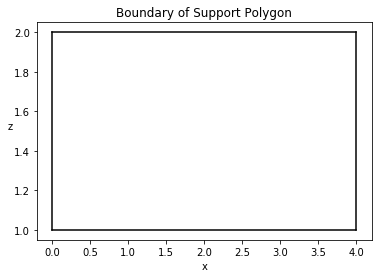

Point (2.000000, 1.500000) is inside the support polygon
Therefore, the structure is stable.
Center of Mass X: 10.777778
Center of Mass Y: 3.833333
Center of Mass Z: 2.500000
[array([8, 2]), array([10,  2]), array([10,  3]), array([8, 3])]


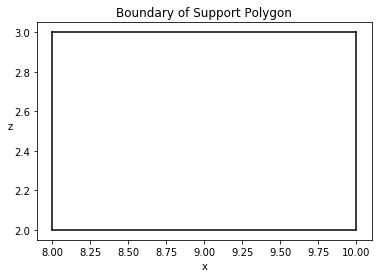

Point (10.777778, 2.500000) is not inside the support polygon
Therefore, the structure is unstable.
{'stability': False, 'structures': 2}


In [16]:

#################################################################################
''' Check /scenarioImages for visual representation in Lego Studio (LEGO CAD) '''
''' All scenarios confirmed using stability feature in Lego Studio (LEGO CAD) '''
''' This block generates a build that should fail stability check: Scenario 1 '''

# # Adding 1x1x2 block (width x length x height)
# array[1][0][0] = '1'
# array[1][1][0] = '1'
#
# # Adding 1x4x1 block on top of 1x1x2 block
# array[1][2][0] = '1'
# array[2][2][0] = '1'
# array[3][2][0] = '1'
# array[4][2][0] = '1'

''' This block generates a build that should pass stability check: Scenario 2 '''

# # Adding 2x4x1 base (width x length x height)
# array[1][0][1] = '1'
# array[2][0][1] = '1'
# array[3][0][1] = '1'
# array[4][0][1] = '1'
# array[1][0][2] = '1'
# array[2][0][2] = '1'
# array[3][0][2] = '1'
# array[4][0][2] = '1'
#
# # Adding 1x1x2 block (width x length x height) on top of base
# array[2][1][1] = '1'
# array[2][2][1] = '1'
#
# # Adding 1x4x1 block on top of 1x1x2 block
# array[2][3][1] = '1'
# array[3][3][1] = '1'
# array[4][3][1] = '1'
# array[5][3][1] = '1'

''' This block generates a build that should pass stability check: Scenario 3 '''

# # Adding 1x1x5 block
# array[1][0][0] = '1'
# array[1][1][0] = '1'
# array[1][2][0] = '1'
# array[1][3][0] = '1'
# array[1][4][0] = '1'
#
# # Adding 1x2x1 block on top
# array[1][5][0] = '1'
# array[2][5][0] = '1'
# array[3][5][0] = '1'

''' This block generates a build with two structures that should pass stability check: Scenario 4 '''

# # Adding 1x4x1 block
# array[0][0][1] = '1'
# array[1][0][1] = '1'
# array[2][0][1] = '1'
# array[3][0][1] = '1'
#
# # Adding 1x4x1 block on top
# array[1][1][1] = '1'
# array[2][1][1] = '1'
# array[3][1][1] = '1'
# array[4][1][1] = '1'
#
# # Adding separate structure
# array[8][0][2] = '1'
# array[9][0][2] = '1'
# array[8][1][2] = '1'
# array[9][1][2] = '1'
# array[8][2][2] = '1'
# array[9][2][2] = '1'
# array[8][3][2] = '1'
# array[9][3][2] = '1'
# array[8][4][2] = '1'
# array[9][4][2] = '1'
#
# array[9][5][2] = '1'
# array[10][5][2] = '1'
# array[11][5][2] = '1'
# array[12][5][2] = '1'

''' This block generates a build with two structures where one fails stability check: Scenario 5 '''

# Adding 1x4x1 block
array[0][0][1] = '1'
array[1][0][1] = '1'
array[2][0][1] = '1'
array[3][0][1] = '1'

# Adding separate structure
array[8][0][2] = '1'
array[9][0][2] = '1'
array[8][1][2] = '1'
array[9][1][2] = '1'
array[8][2][2] = '1'
array[9][2][2] = '1'
array[8][3][2] = '1'
array[9][3][2] = '1'
array[8][4][2] = '1'
array[9][4][2] = '1'

array[9][5][2] = '1'
array[10][5][2] = '1'
array[11][5][2] = '1'
array[12][5][2] = '1'
array[13][5][2] = '1'
array[14][5][2] = '1'
array[15][5][2] = '1'
array[16][5][2] = '1'

''' This block generates an extremely comprehensive build to test boundaries and speed: Scenario 6 '''

# array = numpy.ones((17, 10, 6))

''' Complex one structure build with no border: Scenario 7 '''

# array = numpy.loadtxt('scenario7.txt').reshape((4, 6, 3))

#################################################################################


''' Executing code'''
print(calculate_stability(array, 17, 10, 6))